In [ ]:
%matplotlib inline


# Creating annotated heatmaps

It is often desirable to show data which depends on two independent
variables as a color coded image plot. This is often referred to as a
heatmap. If the data is categorical, this would be called a categorical
heatmap.

Matplotlib's `~matplotlib.axes.Axes.imshow` function makes
production of such plots particularly easy.

The following examples show how to create a heatmap with annotations.
We will start with an easy example and expand it to be usable as a
universal function.


## A simple categorical heatmap

We may start by defining some data. What we need is a 2D list or array
which defines the data to color code. We then also need two lists or arrays
of categories; of course the number of elements in those lists
need to match the data along the respective axes.
The heatmap itself is an `~matplotlib.axes.Axes.imshow` plot
with the labels set to the categories we have.
Note that it is important to set both, the tick locations
(`~matplotlib.axes.Axes.set_xticks`) as well as the
tick labels (`~matplotlib.axes.Axes.set_xticklabels`),
otherwise they would become out of sync. The locations are just
the ascending integer numbers, while the ticklabels are the labels to show.
Finally we can label the data itself by creating a `~matplotlib.text.Text`
within each cell showing the value of that cell.



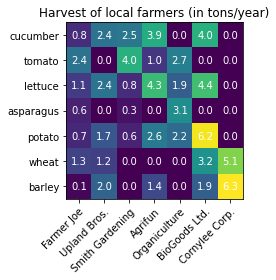

In [3]:
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

vegetables = ["cucumber", "tomato", "lettuce", "asparagus",
              "potato", "wheat", "barley"]
farmers = ["Farmer Joe", "Upland Bros.", "Smith Gardening",
           "Agrifun", "Organiculture", "BioGoods Ltd.", "Cornylee Corp."]

harvest = np.array([[0.8, 2.4, 2.5, 3.9, 0.0, 4.0, 0.0],
                    [2.4, 0.0, 4.0, 1.0, 2.7, 0.0, 0.0],
                    [1.1, 2.4, 0.8, 4.3, 1.9, 4.4, 0.0],
                    [0.6, 0.0, 0.3, 0.0, 3.1, 0.0, 0.0],
                    [0.7, 1.7, 0.6, 2.6, 2.2, 6.2, 0.0],
                    [1.3, 1.2, 0.0, 0.0, 0.0, 3.2, 5.1],
                    [0.1, 2.0, 0.0, 1.4, 0.0, 1.9, 6.3]])


fig, ax = plt.subplots()
im = ax.imshow(harvest)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(farmers)), labels=farmers)
ax.set_yticks(np.arange(len(vegetables)), labels=vegetables)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(vegetables)):
    for j in range(len(farmers)):
        text = ax.text(j, i, harvest[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Harvest of local farmers (in tons/year)")
fig.tight_layout()
plt.show()

## Using the helper function code style

As discussed in the `Coding styles <coding_styles>`
one might want to reuse such code to create some kind of heatmap
for different input data and/or on different axes.
We create a function that takes the data and the row and column labels as
input, and allows arguments that are used to customize the plot

Here, in addition to the above we also want to create a colorbar and
position the labels above of the heatmap instead of below it.
The annotations shall get different colors depending on a threshold
for better contrast against the pixel color.
Finally, we turn the surrounding axes spines off and create
a grid of white lines to separate the cells.



In [4]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

The above now allows us to keep the actual plot creation pretty compact.




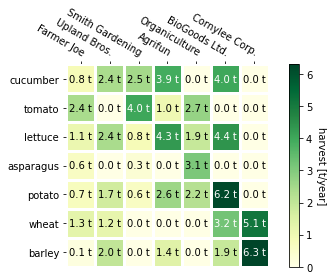

In [5]:
fig, ax = plt.subplots()

im, cbar = heatmap(harvest, vegetables, farmers, ax=ax,
                   cmap="YlGn", cbarlabel="harvest [t/year]")
texts = annotate_heatmap(im, valfmt="{x:.1f} t")

fig.tight_layout()
plt.show()

## Some more complex heatmap examples

In the following we show the versatility of the previously created
functions by applying it in different cases and using different arguments.




AttributeError: 'LinearSegmentedColormap' object has no attribute 'resampled'

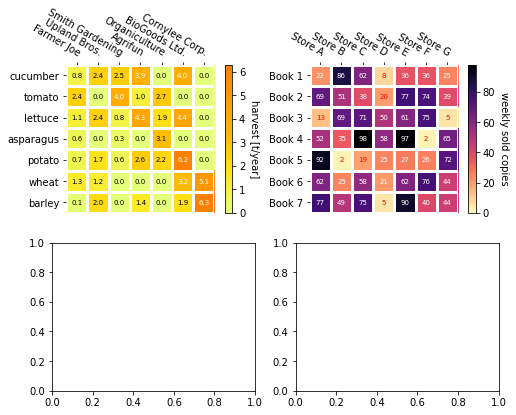

In [6]:
np.random.seed(19680801)

fig, ((ax, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 6))

# Replicate the above example with a different font size and colormap.

im, _ = heatmap(harvest, vegetables, farmers, ax=ax,
                cmap="Wistia", cbarlabel="harvest [t/year]")
annotate_heatmap(im, valfmt="{x:.1f}", size=7)

# Create some new data, give further arguments to imshow (vmin),
# use an integer format on the annotations and provide some colors.

data = np.random.randint(2, 100, size=(7, 7))
y = ["Book {}".format(i) for i in range(1, 8)]
x = ["Store {}".format(i) for i in list("ABCDEFG")]
im, _ = heatmap(data, y, x, ax=ax2, vmin=0,
                cmap="magma_r", cbarlabel="weekly sold copies")
annotate_heatmap(im, valfmt="{x:d}", size=7, threshold=20,
                 textcolors=("red", "white"))

# Sometimes even the data itself is categorical. Here we use a
# `matplotlib.colors.BoundaryNorm` to get the data into classes
# and use this to colorize the plot, but also to obtain the class
# labels from an array of classes.

data = np.random.randn(6, 6)
y = ["Prod. {}".format(i) for i in range(10, 70, 10)]
x = ["Cycle {}".format(i) for i in range(1, 7)]

qrates = list("ABCDEFG")
norm = matplotlib.colors.BoundaryNorm(np.linspace(-3.5, 3.5, 8), 7)
fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: qrates[::-1][norm(x)])

im, _ = heatmap(data, y, x, ax=ax3,
                cmap=mpl.colormaps["PiYG"].resampled(7), norm=norm,
                cbar_kw=dict(ticks=np.arange(-3, 4), format=fmt),
                cbarlabel="Quality Rating")

annotate_heatmap(im, valfmt=fmt, size=9, fontweight="bold", threshold=-1,
                 textcolors=("red", "black"))

# We can nicely plot a correlation matrix. Since this is bound by -1 and 1,
# we use those as vmin and vmax. We may also remove leading zeros and hide
# the diagonal elements (which are all 1) by using a
# `matplotlib.ticker.FuncFormatter`.

corr_matrix = np.corrcoef(harvest)
im, _ = heatmap(corr_matrix, vegetables, vegetables, ax=ax4,
                cmap="PuOr", vmin=-1, vmax=1,
                cbarlabel="correlation coeff.")


def func(x, pos):
    return "{:.2f}".format(x).replace("0.", ".").replace("1.00", "")

annotate_heatmap(im, valfmt=matplotlib.ticker.FuncFormatter(func), size=7)


plt.tight_layout()
plt.show()

.. admonition:: References

   The use of the following functions, methods, classes and modules is shown
   in this example:

   - `matplotlib.axes.Axes.imshow` / `matplotlib.pyplot.imshow`
   - `matplotlib.figure.Figure.colorbar` / `matplotlib.pyplot.colorbar`

